# VKYN TensorFlow (EfficientNet)

For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:

| Base model    | resolution |
|---------------|------------|
| EfficientNetB0 | 224        |
| EfficientNetB1 | 240        |
| EfficientNetB2 | 260        |
| EfficientNetB3 | 300        |
| EfficientNetB4 | 380        |
| EfficientNetB5 | 456        |
| EfficientNetB6 | 528        |
| EfficientNetB7 | 600        |

In [100]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from PIL import Image as pil
from PIL.Image import Image
from shutil import move, copy

from vkyn import *

In [101]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
%autoreload 2

In [103]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [104]:
tf.get_logger().setLevel("ERROR")

In [105]:
DATA = Path("data/vkyn01-dataset-multiclassification")

In [106]:
# def create_dataset(path: Path, labels: bool = True) -> pd.DataFrame:
#     return pd.DataFrame([
#         {
#             "filename": file.name,
#             "label": file.parent.name if labels else None,
#         }
#         for file in path.glob("**/*.jpg")
#     ])

# df = create_dataset(DATA)
# df.sample(10, random_state=42)

In [107]:
SEED = 1337

IMAGE_SIZE = (300, 300) # EfficientNetB3
BATCH_SIZE = 128

# Keras will automatically create labels (0 - n, 1 - y)

training_images = tf.keras.utils.image_dataset_from_directory(
    DATA,
    seed = SEED,
    image_size = IMAGE_SIZE,
    validation_split = 0.7,
    batch_size = BATCH_SIZE,
    subset = "training",
    crop_to_aspect_ratio=True,
)
validation_images = tf.keras.utils.image_dataset_from_directory(
    DATA,
    seed = SEED,
    image_size = IMAGE_SIZE,
    validation_split = 0.15,
    batch_size = BATCH_SIZE,
    subset = "validation",
    crop_to_aspect_ratio=True,
)
test_images = tf.keras.utils.image_dataset_from_directory(
    DATA,
    seed = SEED,
    image_size = IMAGE_SIZE,
    validation_split = 0.15,
    batch_size = BATCH_SIZE,
    subset = "validation",
    crop_to_aspect_ratio=True,
)

Found 7175 files belonging to 13 classes.
Using 2153 files for training.
Found 7175 files belonging to 13 classes.
Using 1076 files for validation.
Found 7175 files belonging to 13 classes.
Using 1076 files for validation.


In [108]:
len(validation_images)

9

In [109]:
CLASS_NAMES = training_images.class_names

In [110]:
CLASS_NAMES

['activity',
 'animal',
 'city',
 'indoor',
 'kebab',
 'nature',
 'object',
 'other',
 'outdoor',
 'painting',
 'people',
 'transport',
 'vegetable']

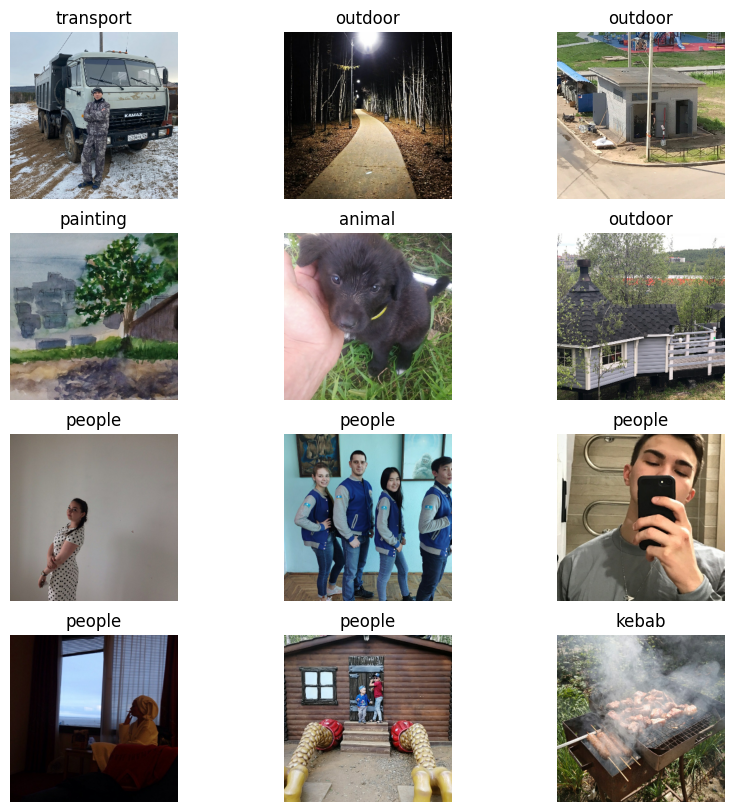

In [111]:
plt.figure(figsize=(10, 10))
for images, labels in training_images.take(1):
    for i in range(12):
        label = training_images.class_names[int(labels[i])]
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")

In [112]:
with tf.device("/cpu:0"):
  image_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal", seed=42),
      tf.keras.layers.RandomFlip("vertical", seed=43),
      tf.keras.layers.RandomRotation(0.2, seed=44),
      tf.keras.layers.RandomZoom(0.2, seed=45),
      tf.keras.layers.RandomContrast(0.4, seed=46),
      tf.keras.layers.RandomBrightness(0.3, seed=47),
      tf.keras.layers.RandomTranslation(0.2, 0.2, seed=48),
  ])

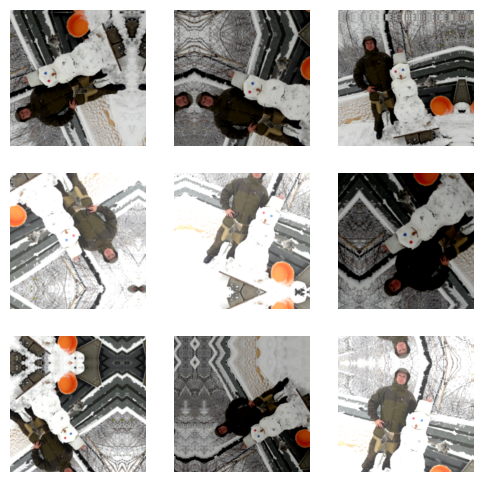

In [113]:
image, label = next(iter(training_images))

plt.figure(figsize=(6, 6))

for i in range(9):
    augmented_image = image_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [114]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False, augment_multiplier=3):
  # Resize and rescale all datasets.
  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    # Original dataset
    original_ds = ds

    # Create augmented versions
    augmented_datasets = [original_ds]
    
    # Add multiple augmented versions of the dataset
    for i in range(augment_multiplier - 1):
      aug_ds = original_ds.map(
          lambda x, y: (image_augmentation(x, training=True), y), 
          num_parallel_calls=AUTOTUNE
      )
      augmented_datasets.append(aug_ds)
    
    # Optional: Add dataset with stronger augmentations for more variety
    # strong_aug_ds = original_ds.map(
    #     lambda x, y: (image_augmentation_strong(x, training=True), y),
    #     num_parallel_calls=AUTOTUNE
    # )
    # augmented_datasets.append(strong_aug_ds)
    
    # Concatenate all datasets
    ds = augmented_datasets[0]
    for aug_ds in augmented_datasets[1:]:
      ds = ds.concatenate(aug_ds)
    
    # Shuffle again after concatenation
    if shuffle:
      ds = ds.shuffle(1000 * augment_multiplier)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [115]:
training_images = prepare(training_images, shuffle=True, augment=True)
validation_images = prepare(validation_images)

In [116]:
def build_model(input_shape, num_classes: int, dropout_rate: float):
    inputs = tf.keras.layers.Input(shape=input_shape)
    cnn = tf.keras.applications.EfficientNetB5(
        input_tensor=inputs,
        include_top=False,
        weights="imagenet",
        classes=13,
    )

    # Freeze the pretrained weights
    cnn.trainable = False

    # Rebuild top
    avg_pool = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(cnn.output)
    x = tf.keras.layers.BatchNormalization()(avg_pool)

    # Dropout
    if dropout_rate > 0:
        x = tf.keras.layers.Dropout(dropout_rate, name="top_dropout")(x)

    # Output
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    outputs = tf.keras.layers.Dense(units, activation=activation, name="pred")(x)

    return tf.keras.Model(inputs, outputs, name="VKYN01"), (inputs, cnn, avg_pool, outputs)

In [117]:
# Create an instance of model
model, _ = build_model(
    input_shape=IMAGE_SIZE + (3,),
    # TODO: make the values for the num_classes variable
    num_classes=13,
    dropout_rate=0.3,
)

In [118]:
BASE_MODEL = model

In [119]:
BASE_MODEL.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [22]:
BASE_MODEL.evaluate(validation_images)

9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.1269 - loss: 2.5422


[2.543119192123413, 0.1217472106218338]

## load weights if it was pre-trained

# Load weights in Keras format(h5)
model.load_weights("./weights/tf-efficientnetb5_multiclass_50epoch_dropout04_learningrate1e-4_epochs.keras")

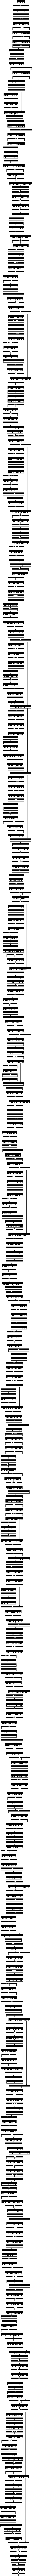

In [120]:
# Visualize model
tf.keras.utils.plot_model(model, show_shapes = True)

In [121]:
# We will save weight of model after each epoch of training in Keras (h5) format.
callbacks = [
    #tf.keras.callbacks.ModelCheckpoint("vkyn01-checkpoints/epoch03_{epoch}.keras"),
    # tf.keras.callbacks.CSVLogger(filename="vkyn01-training.log", separator=",", append=False),
    # tf.keras.callbacks.EarlyStopping(
    #     monitor="val_loss",
    #     patience=7,
    #     verbose=1,
    #     # min_delta=0,
    #     # mode="auto",
    #     # baseline=None,
    #     # restore_best_weights=False
    # ),
    # tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss",
    #     factor=0.25,
    #     patience=2,
    #     min_lr=0.0001,
    # ),
    # tf.keras.callbacks.TensorBoard("log_dir/name"),
]

# We unfreeze the top N layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        continue
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # for training head layer

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # for training last 20 layers
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # for training last 20 layers
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025) # for training last 20 layers

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
# model.summary()

In [122]:
model.load_weights("./weights/tf-efficientnetb5_multiclass_50epoch_dropout04_learningrate1e-4_epochs.keras")

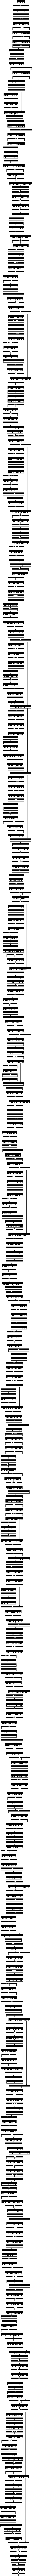

In [124]:
# Visualize model
tf.keras.utils.plot_model(model, show_shapes = True)

In [123]:
# EPOCHS = 5
EPOCHS = 50
## TODO: the accuracy can still be upgraded by 
# separating the files/getting more train data for the dataset
history = model.fit(
    training_images,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_images,
)

Epoch 1/50


KeyboardInterrupt: 

In [27]:
# model.save(f'weights/tf-efficientnetb5_multiclass_{EPOCHS}epoch_dropout04_learningrate1e-4_epochs.keras')

In [88]:
def plot_accuracy(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


def plot_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

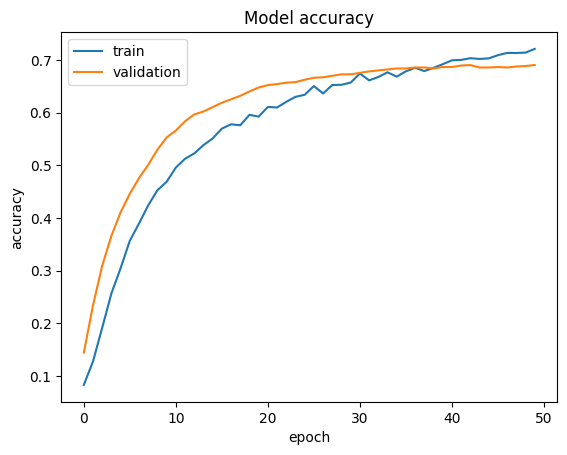

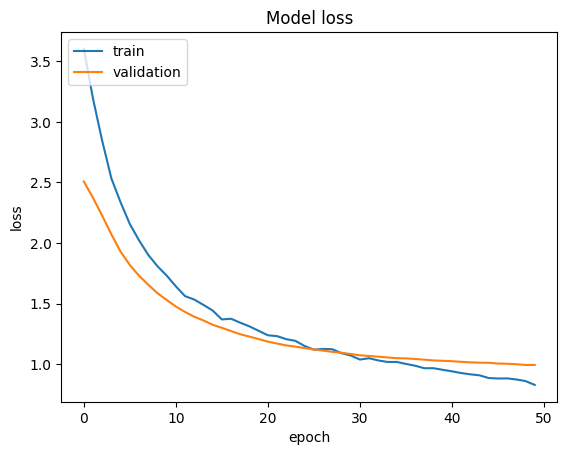

In [89]:
# print("epochs=20; 8k; LR=1e-4; size=384; EfficientNetV2-s ImageNet; with augmentation; dropout=0.25; train last 20 layers")
plot_accuracy(history)
plot_loss(history)

## Validate Model

In [87]:
import numpy as np
from scipy import stats

In [88]:
def process_image(path: Path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array

def predict_image(model, path: Path):
    img_array = process_image(path)
    predictions = model.predict(img_array, verbose=1)
    
    # Print raw predictions
    print(predictions[0])
    
    # Get the class with highest probability
    predicted_class_idx = np.argmax(predictions[0])
    predicted_probability = predictions[0][predicted_class_idx]
    
    result = {
        "class_index": int(predicted_class_idx),
        "probability": float(predicted_probability),
        "class_name": CLASS_NAMES[predicted_class_idx]
    }
      
    return result

In [19]:
# # Create an instance of model
# model, _ = build_model(
#     input_shape=IMAGE_SIZE + (3,),
#     # TODO: make the values for the num_classes variable
#     num_classes=13,
#     dropout_rate=0.3,
# )

In [91]:
model.load_weights("./weights/tf-efficientnetb5_multiclass_50epoch_dropout04_learningrate1e-4_epochs.keras")

In [90]:
%time model.evaluate(test_images)

9/9 ━━━━━━━━━━━━━━━━━━━━ 75s 8s/step - accuracy: 0.6856 - loss: 1.0180
CPU times: total: 9min 16s
Wall time: 1min 15s


[0.993964433670044, 0.6905204653739929]

In [98]:
exampleImages = ["./data/vaska_clean/-486_359189381.jpg", "./data/vaska_clean/34942_456240674.jpg", "./data/vaska_clean/-5066242_457285494.jpg", "./data/vaska_clean/3426_457241363.jpg"]

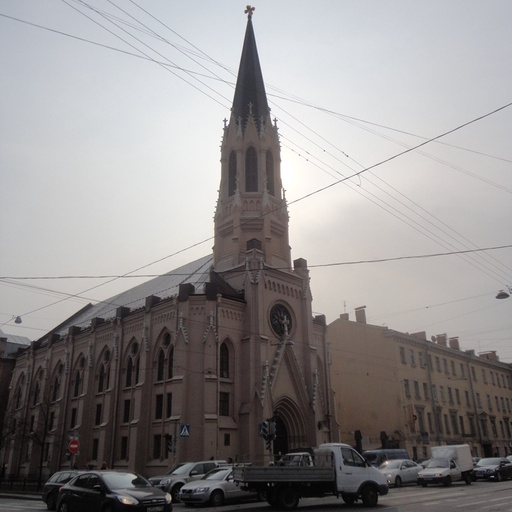

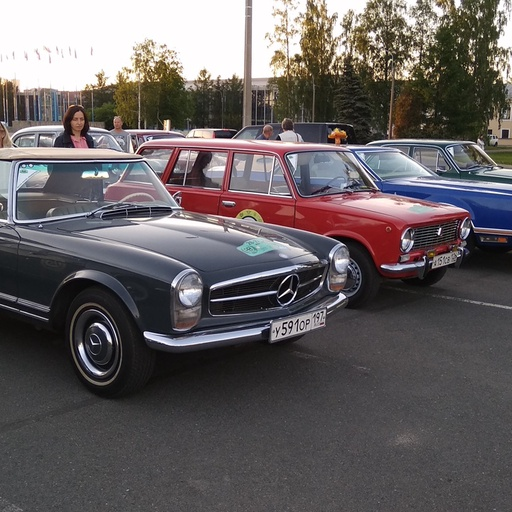

In [32]:
from IPython.display import Image
for n in exampleImages:
    display(Image(filename=n))

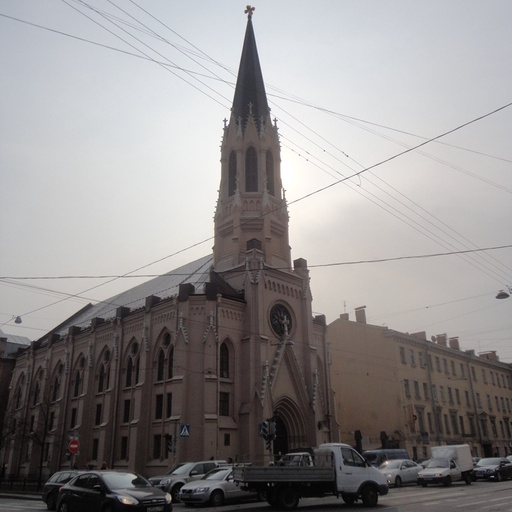

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
[3.78445024e-03 8.79205987e-02 5.80217123e-01 3.97947617e-03
 1.26203345e-02 2.62371800e-03 1.15731475e-03 3.12304730e-03
 2.76886821e-01 3.44858901e-03 1.98037873e-04 2.15345323e-02
 2.50597694e-03]
city


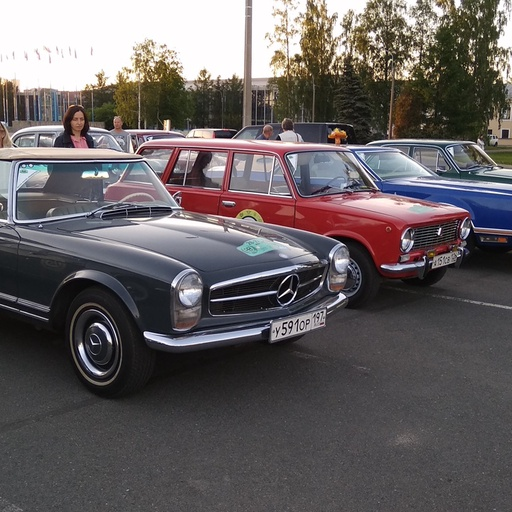

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
[1.2937711e-03 4.2618979e-03 3.4161173e-03 1.4774554e-03 3.1912210e-03
 4.8514982e-03 7.2477281e-04 2.1693236e-03 6.5141346e-04 1.4398408e-03
 2.4109449e-04 9.7319984e-01 3.0816873e-03]
transport


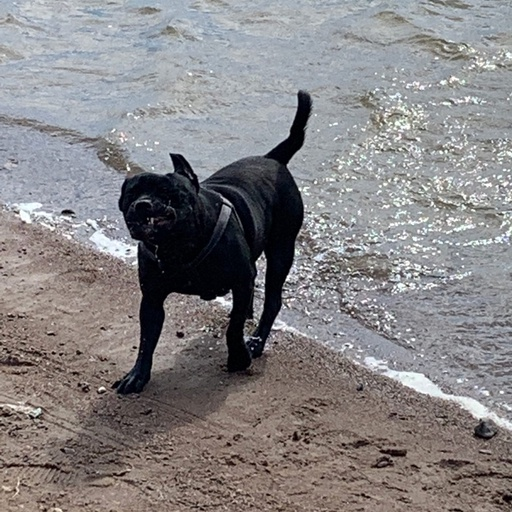

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
[1.4308313e-02 8.1925768e-01 5.6230411e-04 4.7311559e-02 3.4215428e-02
 3.2961606e-03 2.2718843e-02 2.7163208e-03 1.2028912e-02 3.8772372e-03
 3.9882972e-05 2.8615592e-02 1.1051806e-02]
animal


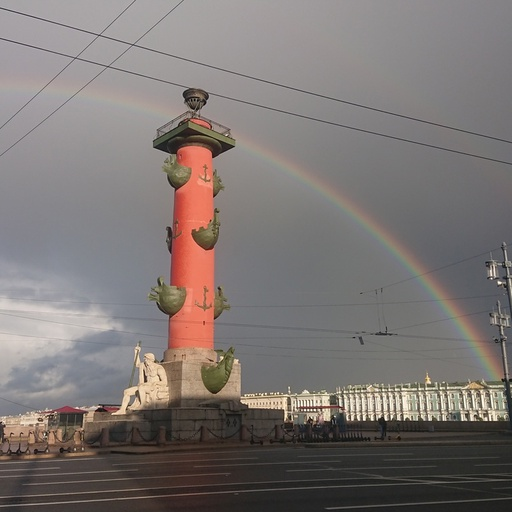

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[0.00146886 0.0133135  0.03820059 0.00288837 0.00110981 0.00466158
 0.00338446 0.00084689 0.8255087  0.00727686 0.0009134  0.09913168
 0.00129536]
outdoor


In [99]:
for n in exampleImages:
    display(Image(n))
    # print(predict_image(model, Path(n)))
    prediction = predict_image(model, Path(n))
    print(f"{prediction['class_name']}")

In [84]:
n = 1076
new_model_accuracy = 0.69
base_model_accuracy = 0.48

In [85]:
std_error = np.sqrt((new_model_accuracy * (1 - new_model_accuracy)) / n)
print(f"std_error: {std_error}")

# 95% доверительный интервал
z = 1.96  # z-значение для 95% доверительного интервала
margin_error = z * std_error
ci_lower = new_model_accuracy - margin_error
ci_upper = new_model_accuracy + margin_error

print(f"Точность: {new_model_accuracy:.2f}, 95% Доверительный интервал: [{ci_lower:.4f}, {ci_upper:.4f}]")

std_error: 0.014099355359779336
Точность: 0.69, 95% Доверительный интервал: [0.6624, 0.7176]


In [86]:
from scipy.stats import binomtest

# Количество правильных предсказаний
correct = int(new_model_accuracy * n)
print(f"Approximate correct: {correct}")

result = binomtest(correct, n, base_model_accuracy, alternative='greater')
print(f"p-значение: {result.pvalue:.2e}")

Approximate correct: 742
p-значение: 5.45e-44
